In [1]:
import SAME_ECOS_functions as se
from SAME_ECOS_functions import *
import time
import datetime
import numpy as np
import scipy.io as sio
import math
import itertools

# Produce training data

In [255]:
def t2star_location(my_mu=12, my_sigma=1, ax_mu=72, ax_sigma=10, ex_mu=60, ex_sigma=6):
    
    while True:
        t2_my = np.random.normal(my_mu, my_sigma)
        t2_ax = np.random.normal(ax_mu, ax_sigma)
        t2_ex = np.random.normal(ex_mu, ex_sigma)
        if all([t2_my, t2_ax, t2_ex]) > 0:
            break
    return np.asarray([t2_my, t2_ax, t2_ex])

In [193]:
def t2star_amplitude(mwf_upper_bound=0.5):
    mwf = np.random.uniform(0, mwf_upper_bound)
    axwf = np.random.uniform(0, 1) * (1 - mwf)
    exwf = 1 - mwf - axwf
    
    return np.asarray([mwf, axwf, exwf])

In [364]:
def mgre_signal(T2_location, T2_amplitude, TE, model=1):
    signal = np.zeros(TE.shape[0])
    alpha = (22/180)*math.pi
    TR = 100
    T1 = np.asarray([200,800,800])
    T1_correction = np.sin(alpha)*(1-np.exp(-TR/T1))/(1-np.cos(alpha)*np.exp(-TR/T1))
    
    for t2_amp, t2_loc, t1_corr in zip(T2_amplitude, T2_location, T1_correction):
        if model == 1:
            signal += t2_amp * np.exp(-TE/t2_loc)
        if model == 2:
            signal += t2_amp * np.exp(-TE/t2_loc) * t1_corr
            
    return signal

In [365]:
def produce_3_pool_data(realizations=10000,
                        SNR_boundary_low=50,
                        SNR_boundary_high=300,
                        TE=np.arange(2, 50, 2),
                        #                       echo_1st=2,
                        #                       echo_last=48,
                        #                       echo_spacing=2,
                        #                       num_t2_basis=20,
                        #                       peak_width=1,
                        #                       T2_min_universal=3,
                        #                       T2_max_universal=300,
                        #                       exclude_M_max=False
                        ):
    """
    Produce training data via SAME-ECOS simulation pipeline (use a single cpu core).

    Returns:
        data: dictionary collection of the produced training data
    """

    # Define T2 range, maximum number (M_max) of T2 peaks at the highest SNR, allowable number (N) of T2 peaks for simulation
#     TE = np.arange(echo_1st, echo_last+echo_spacing, echo_spacing)
    echo_train_num = TE.shape[0]
#     if T2_min_universal == None:
#         # Lower boundary is determined by the highest SNR
#         T2_min_universal, _ = T2_boundary(SNR_boundary_high, echo_3, echo_last)
#     if T2_max_universal == None:
#         T2_max_universal = 2000  # empirically determined
#     t2_basis = t2_basis_generator(
#         T2_min_universal, T2_max_universal, num_t2_basis)
#     M_max = int(np.floor(T2_components_resolution_finite_domain(
#         SNR_boundary_high, T2_min_universal, T2_max_universal)))  # M at highest SNR
#     # resolution_max = resloution_limit(T2_min_universal, T2_max_universal, M_max) ## resolution at highest SNR
#     if exclude_M_max == True:
#         N = M_max - 1  # for simulation M_max is excluded
#     else:
#         N = M_max
    # Create placeholders for memory efficiency
    T2_location_all = np.zeros([realizations, 3])
    T2_amplitude_all = np.zeros([realizations, 3])
    decay_curve_all = np.zeros([realizations, echo_train_num])
    decay_curve_with_noise_all = np.zeros([realizations, echo_train_num])
#     train_label_all = np.zeros([realizations, num_t2_basis])
#     train_label_gaussian_all = np.zeros([realizations, num_t2_basis])
    SNR_all = np.zeros([realizations, 1])
    # For each realization
    for i in range(realizations):
        # Randomly determine the SNR, the minimum T2, the number of T2s (must < M), and the flip angle FA.
        # SNR = 100 ## for fixed SNR
        SNR = np.random.randint(SNR_boundary_low, SNR_boundary_high)
#         T2_min, _ = T2_boundary(SNR, TE[2], TE[-1])
#         if T2_min < T2_min_universal:
#             T2_min = T2_min_universal
#         T2_max = T2_max_universal
#         M = np.floor(T2_components_resolution_finite_domain(
#             SNR, T2_min, T2_max))
#         if exclude_M_max == True:
#             N_choice = np.arange(1, M)
#         else:
#             N_choice = np.arange(1, M+1)
#         weight = N_choice**0.2  # weighting factor for each choice
#         num_T2 = int(np.random.choice(N_choice, p=weight/weight.sum()))
#         # Calculate the resolution limit
#         resolution = resloution_limit(T2_min, T2_max, M)
#         # Randomly generate T2 peak location with respect to resolution limit.
#         #T2_location = T2_location_generator_v3(T2_min, T2_max, num_T2, num_t2_basis, resolution, log_cutoff=10, smooth=False)
#         T2_location = T2_location_generator_v3(
#             T2_min, T2_max, num_T2, M_max, scale='log')
#         while T2_resolution_examiner(T2_location, resolution) == False:
#             T2_location = T2_location_generator_v3(
#                 T2_min, T2_max, num_T2, M_max, scale='log')
#         # Randomly generate T2 peak amplitude. When two or more peaks, minimal detectable amplitude is calculated
#         if num_T2 == 1:
#             T2_amplitude = np.array([1.0])
#         else:
#             _, frequency = required_frequency(T2_location)
#             minimum_amplitude = minimum_amplitude_calculator(SNR, frequency)
#             T2_amplitude = T2_amplitude_generator_v3(num_T2, minimum_amplitude)
        # Decay curve generation (weighted sum of each T2 component)
        T2_location = t2star_location()
        T2_amplitude = t2star_amplitude()
        decay_curve = mgre_signal(T2_location, T2_amplitude, TE, model=2)
        # Add noise to decay curve
        decay_curve_with_noise = signal_with_noise_generation_phase_rotation(
            signal=decay_curve, SNR=SNR)
        # T2 basis set embedding (nearest t2_basis neighbors)
#         train_label = train_label_generator(
#             T2_location, T2_amplitude, t2_basis)
#         # T2 basis set embedding (gaussian peaks)
#         train_label_gaussian = train_label_generator_gaussian_embedding(
#             T2_location, T2_amplitude, T2_min_universal, T2_max_universal, t2_basis, peak_width)
        # Extract metrics (use t2_basis and train label instead of T2_location and T2_amplitude to prevent basis set embedding error)
        #MWF, MWGMT2, IEWF, IEWGMT2, GMT2 = metrics_extraction_v3(t2_basis, train_label, MW_low_cutoff, MW_high_cutoff, IEW_low_cutoff, IEW_high_cutoff)
        # Ground truth metrics (use tT2_location and T2_amplitude)
        #MWF_GT, MWGMT2_GT, IEWF_GT, IEWGMT2_GT, GMT2_GT = metrics_extraction_v3(T2_location, T2_amplitude, MW_low_cutoff, MW_high_cutoff, IEW_low_cutoff, IEW_high_cutoff)
        # Pad T2_location and T2_amplitude to have uniform size
#         T2_location = np.pad(
#             T2_location, [(0, N-int(num_T2))], mode='constant', constant_values=0)
#         T2_amplitude = np.pad(
#             T2_amplitude, [(0, N-int(num_T2))], mode='constant', constant_values=0)
        # Store generated parameters in placeholders
        T2_location_all[i, :] = T2_location
        T2_amplitude_all[i, :] = T2_amplitude
        decay_curve_all[i, :] = decay_curve
        decay_curve_with_noise_all[i, :] = decay_curve_with_noise
#         train_label_all[i, :] = train_label
#         train_label_gaussian_all[i, :] = train_label_gaussian
        SNR_all[i, :] = SNR
    # return a data dict
    data = {'T2_location': T2_location_all,
            'T2_amplitude': T2_amplitude_all,
            'decay_curve': decay_curve_all,
            'decay_curve_with_noise': decay_curve_with_noise_all,
            #             'train_label': train_label_all,
            #             'train_label_gaussian': train_label_gaussian_all,
            'SNR': SNR_all,
            }
    return data

In [366]:
np.arange(2, 50, 4)

array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46])

In [367]:
def mp_yield_mgre_data(produce_3_pool_data,
                       ncores=8,
                       realizations=10000,
                       SNR_boundary_low=50,
                       SNR_boundary_high=300,
                       TE=np.arange(2, 50, 4)):
    """
    Use multiple cpu cores to accelerate training data production using multiprocessing package.

    Args:
        func_produce_training_data (function): the function to produce training data using a single cpu core.
        decay_lib (array): the decay library.
        realizations (int): the number of simulation realizations.
        ncores (int): number of cpu cores to use.
        SNR_boundary_low (float, optional): lower boundary of SNR. Defaults to 50.
        SNR_boundary_high (float, optional): upper boundary of SNR. Defaults to 800.
        echo_3 (float, optional): the 3rd echo time (ms). Defaults to 30.
        echo_last (float, optional): the last echo time (ms). Defaults to 320.
        echo_train_num (int, optional): the number of echoes in the echo train. Defaults to 32.
        num_t2_basis (int, optional): the number of basis t2s. Defaults to 40.
        FA_min (float, optional): the minimal refocusing flip angle for simulation. Defaults to 50.
        peak_width (float, optional): the variance of the gaussian peak. Defaults to 1.
        T2_min_universal (float, optional): the overall minimal T2 (ms) of the analysis. Defaults to calculate on the fly if None is given.
        T2_max_universal (float, optional): the overall maximal T2 (ms) of the analysis. Defaults to to 2000ms if None is given.
        exclude_M_max (bool, optional): exclude the M_max if True. Defaults to True.

    Returns:
        data_all: a data dictionary concatenated from all cpu cores
    """

    import multiprocessing as mp
    pool = mp.Pool(processes=ncores)
    # distribute job to each cpu core
    realizations_pool_list = [realizations//ncores]*ncores
    if realizations % ncores != 0:
        realizations_pool_list.append(realizations % ncores)
    data = pool.starmap(produce_3_pool_data, [(realizations,
                                               SNR_boundary_low,
                                               SNR_boundary_high,
                                               TE)
                                              for realizations in realizations_pool_list])
    pool.close()
    pool.join()
    # concatenate data calculated from each cpu core
    keys = data[0].keys()
    data_all = {key: None for key in keys}
    for key in keys:
        data_all[key] = np.concatenate(
            [data[x][key] for x in range(len(data))])
    return data_all

In [198]:
np.arange(2, 50, 2)

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48])

In [368]:
data = mp_yield_mgre_data(produce_3_pool_data,
                          ncores=8,
                          realizations=1000000,
                          SNR_boundary_low=100,
                          SNR_boundary_high=500,
                          TE=np.arange(2, 50, 2))

In [369]:
data['T2_amplitude']

array([[0.37142158, 0.15815874, 0.47041968],
       [0.34761931, 0.2350425 , 0.41733819],
       [0.23881033, 0.5826257 , 0.17856397],
       ...,
       [0.28192308, 0.20348788, 0.51458904],
       [0.15594993, 0.67372645, 0.17032362],
       [0.48153583, 0.48720763, 0.03125653]])

In [370]:
data['decay_curve_with_noise'].shape

(1000000, 24)

# Model training

In [371]:
import sklearn
import tensorflow as tf
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

In [372]:
### store training input data in variable x
x = data['decay_curve_with_noise']
### normalization the input data to its first echo
x=x/x[:,0].reshape(x.shape[0],1) 
x.shape

(1000000, 24)

In [373]:
### store training label in variable y
y = data['T2_amplitude']
y = y[:,0]
y = y.reshape(y.shape[0],1)
y.shape

(1000000, 1)

In [374]:
### split the dataset into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=10)

In [375]:
print('training x: '+ str(x_train.shape))
print('training y: '+ str(y_train.shape))
print('validation x: '+ str(x_val.shape))
print('validation y: '+ str(y_val.shape))
print('testing x: '+ str(x_test.shape))
print('testing y: '+ str(y_test.shape))

training x: (810000, 24)
training y: (810000, 1)
validation x: (90000, 24)
validation y: (90000, 1)
testing x: (100000, 24)
testing y: (100000, 1)


In [376]:
### Setting up neural network hyperparameters
hidden_layers=[500, 500, 500, 500, 500, 500] # a list of nodes in each hidden layer and can be changed as you wish
output_layer_nodes = y.shape[1]
Batch_norm = 'yes' # use batch normalization
acti='relu' # activation function
initial='he_normal' # weight initialization
selected_metrics=[tf.keras.metrics.mean_absolute_error]
selected_optimizer = keras.optimizers.Adamax(lr=0.001)
# loss_function = 'cosine_similarity'
# loss_function = 'categorical_crossentropy' # other loss functions can be used as well.
loss_function = 'mean_absolute_error'
l1_strength = 0 # L1 regularization parameter
l2_strength = 0 # L2 regularization parameter
num_epoch = 25

In [377]:
### Train and test the neural network model, and store training and testing history in 'NN_training.txt'
f = open("NN_training.txt", "a")
now = datetime.datetime.now()
f.write("Date and Time: {} \n".format(now.strftime("%Y-%m-%d %H:%M:%S")))
f.write('selected hidden layer structure = {} \n'.format(hidden_layers))
f.write('activation = {}, initialization = {} \n'.format(acti, initial))
f.write('Batch_norm = {}, loss_function = {}, regularization_strength = {},\nselected_optimizer = {} \n \n \n'.format(
    Batch_norm, loss_function, l2_strength, selected_optimizer))

keras.backend.clear_session()
model = keras.Sequential()
if Batch_norm == 'yes':
    model.add(keras.layers.BatchNormalization())
for nodes in hidden_layers:
    model.add(keras.layers.Dense(
        nodes, kernel_initializer=initial, activation=acti))
    if Batch_norm == 'yes':
        model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(output_layer_nodes, kernel_initializer=initial, activation='relu',
          activity_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)))

model.compile(optimizer=selected_optimizer, loss=loss_function, metrics=selected_metrics)

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=15),
                  keras.callbacks.ModelCheckpoint(filepath='NN_3_pool_model_example.h5',monitor='mean_absolute_error',save_best_only=True),
                  keras.callbacks.ReduceLROnPlateau(monitor='mean_absolute_error', factor=0.5, patience=2)]

start_time = time.time()
history = model.fit(x_train, y_train, epochs=num_epoch, batch_size=256,
                    callbacks=callbacks_list, validation_data=(x_val, y_val))

print("--- %.2f seconds ---" % (time.time() - start_time))
f.write("--- Training time %.2f seconds --- \n" % (time.time() - start_time))
print('training stopped at epoch = {}'.format(len(history.history['lr'])))
f.write('training stopped at epoch = {} \n \n'.format(
    len(history.history['lr'])))
f.write('validation mean_absolute_error = {} \n \n'.format(list(round(i, 4)
        for i in history.history['val_mean_absolute_error'])))
f.write('learning rate = {} \n \n'.format(list(round(i, 6)
        for i in history.history['lr'])))

### apply trained model to the test set
NN_predict = model.predict(x_test)

### evaluate the model performance using cosine similarity scores
MAE = np.zeros((y_test.shape[0], 1))
for item in range(y_test.shape[0]):
    MAE[item, :] = mean_absolute_error(
        NN_predict[item, :].reshape(1, -1), y_test[item, :].reshape(1, -1))
print('Average mean_absolute_error in the test set = {} +/- {} \n'.format(
    MAE.mean(), MAE.std()))
f.write('Average mean_absolute_error in the test set = {} +/- {} \n'.format(
    MAE.mean(), MAE.std()))
f.write('#############################################\n')
f.write('\n \n')
f.close()

Epoch 1/25
3165/3165 [==============================] - 23s 7ms/step - loss: 0.0965 - mean_absolute_error: 0.0965 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 2/25
3165/3165 [==============================] - 22s 7ms/step - loss: 0.0291 - mean_absolute_error: 0.0291 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 3/25
3165/3165 [==============================] - 22s 7ms/step - loss: 0.0267 - mean_absolute_error: 0.0267 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 4/25
3165/3165 [==============================] - 22s 7ms/step - loss: 0.0262 - mean_absolute_error: 0.0262 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306
Epoch 5/25
3165/3165 [==============================] - 22s 7ms/step - loss: 0.0261 - mean_absolute_error: 0.0261 - val_loss: 0.0261 - val_mean_absolute_error: 0.0261
Epoch 6/25
3165/3165 [==============================] - 22s 7ms/step - loss: 0.0256 - mean_absolute_error: 0.0256 - val_loss: 0.0263 - val_mean_absolute_error: 0.026

In [170]:
# model = keras.models.load_model('NN_3_pool_model_example.h5')

In [ ]:
### uncomment the line below if you want to save the trained model
# model.save('NN_3-pool_model.h5')

# Apply trained model to experimental data

In [378]:
import nibabel as nib
from dipy.denoise.gibbs import gibbs_removal
from dipy.denoise.localpca import mppca

In [379]:
file_path = 'mGRE_T2star.nii' # replace with the path to your MWI image data in nii or nii.gz or mnc format
img = nib.load(file_path)
img_data = img.get_fdata()
img_data.shape

(135, 106, 120, 24)

In [380]:
mask =  nib.load('mGRE_T2star_bet_mask.nii.gz')
mask = mask.get_fdata()
mask.shape

(135, 106, 120)

In [381]:
mask = np.swapaxes(mask,0,2)
mask.shape

(120, 106, 135)

In [382]:
#img_data = gibbs_removal(img_data, slice_axis=0, inplace=False)

In [383]:
#img_datag = mppca(img_data)

In [384]:
# The last dimension should be the time axis (echoes)
img_data = np.swapaxes(img_data,0,2)
img_data.shape

(120, 106, 135, 24)

In [385]:
#img_data = img_data[:,:,:,0:25:2]

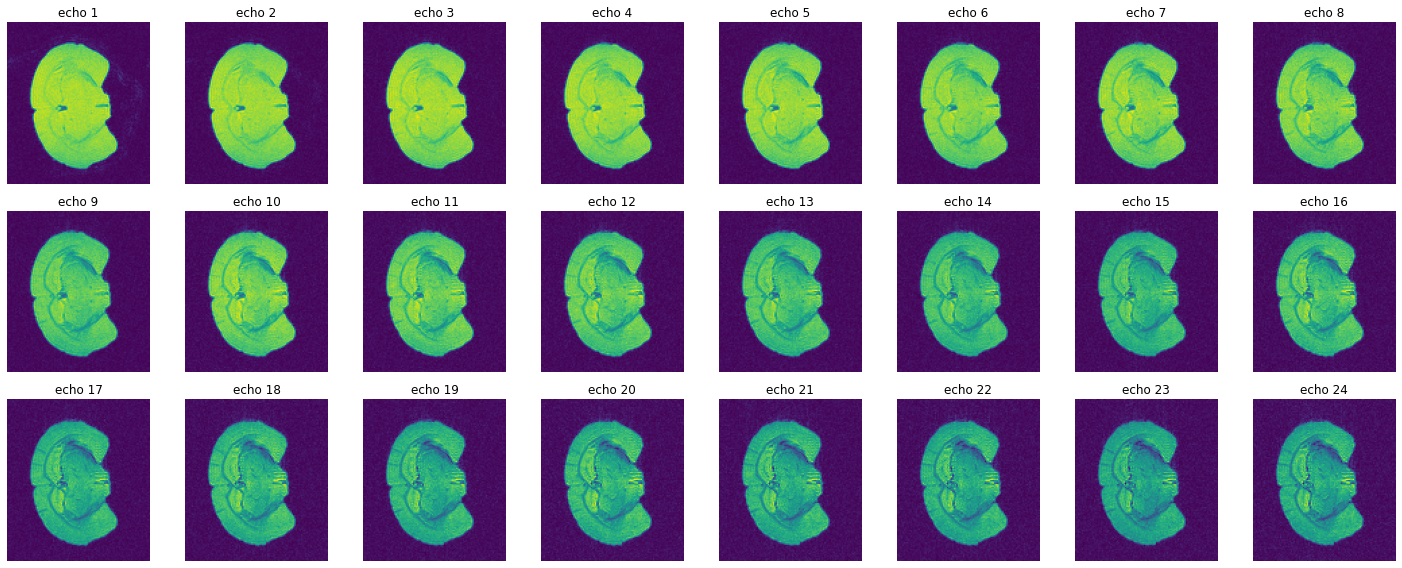

In [386]:
# The following function plots the 32 echoes for the 8th slice.
se.plot_all_echoes(img_data, slice_num=70, rows=3, columns=8, fig_size=(20,8), tight=True)

In [387]:
### Carry out the T2 spectrum using the neural network model trained above
NN_predict = se.NN_predict_4D_decay(img_data, model)

In [391]:
NN_predict = NN_predict[:,:,:,0] * mask

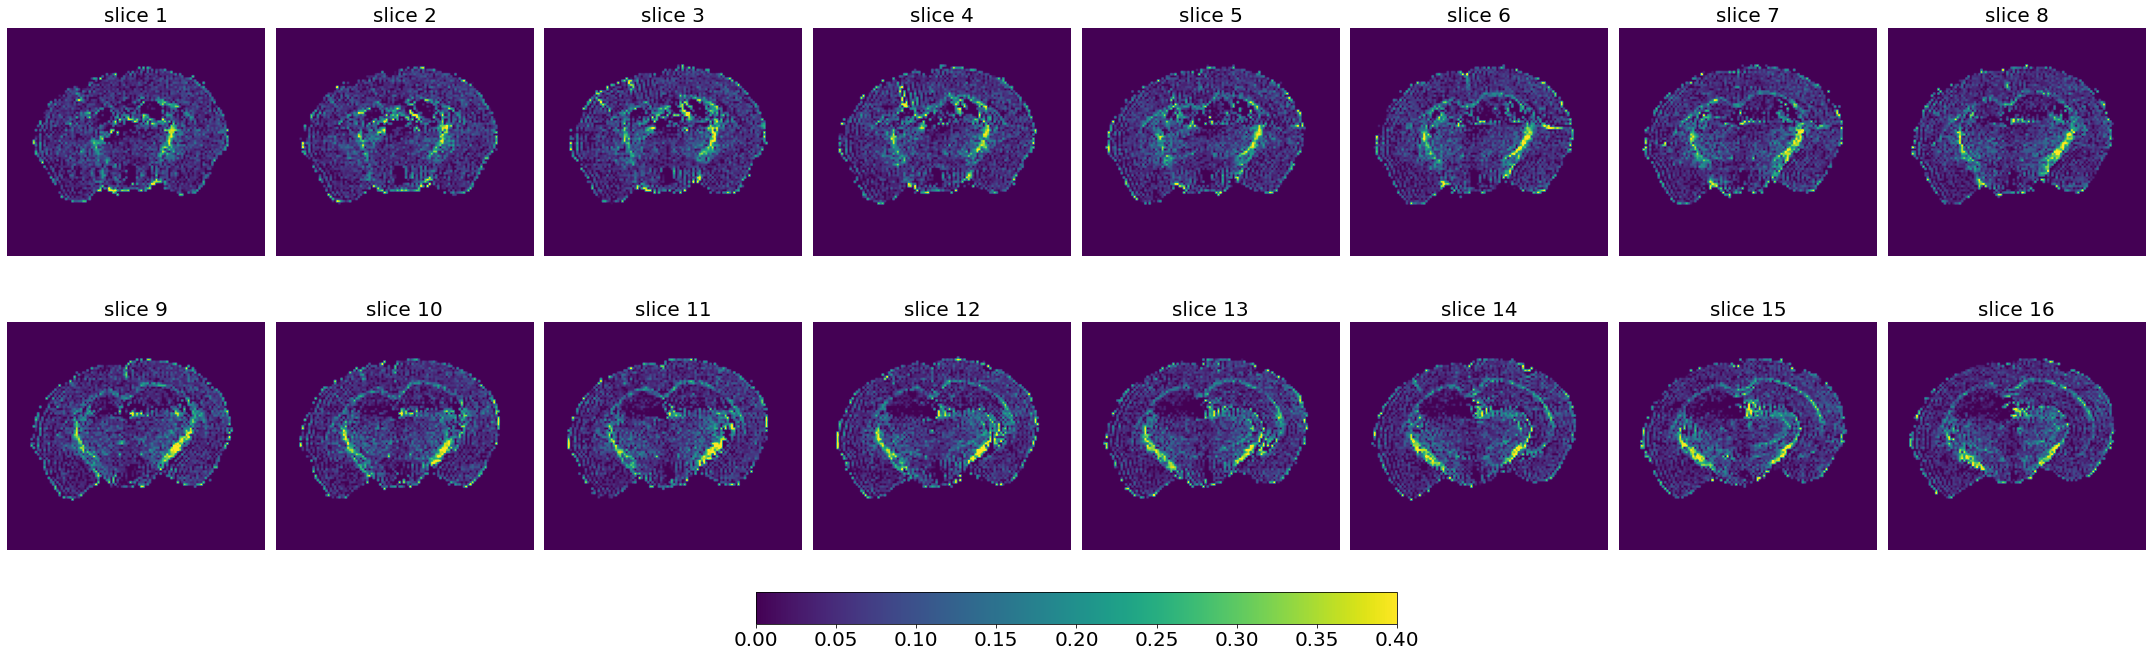

In [431]:
# [12,72,60], [300, 1000, 800], 24 echoes
se.plot_all_slice(np.rot90(NN_predict[:,:,60:76],3), nrow=2, ncol=8, vmin=0, vmax=0.4)

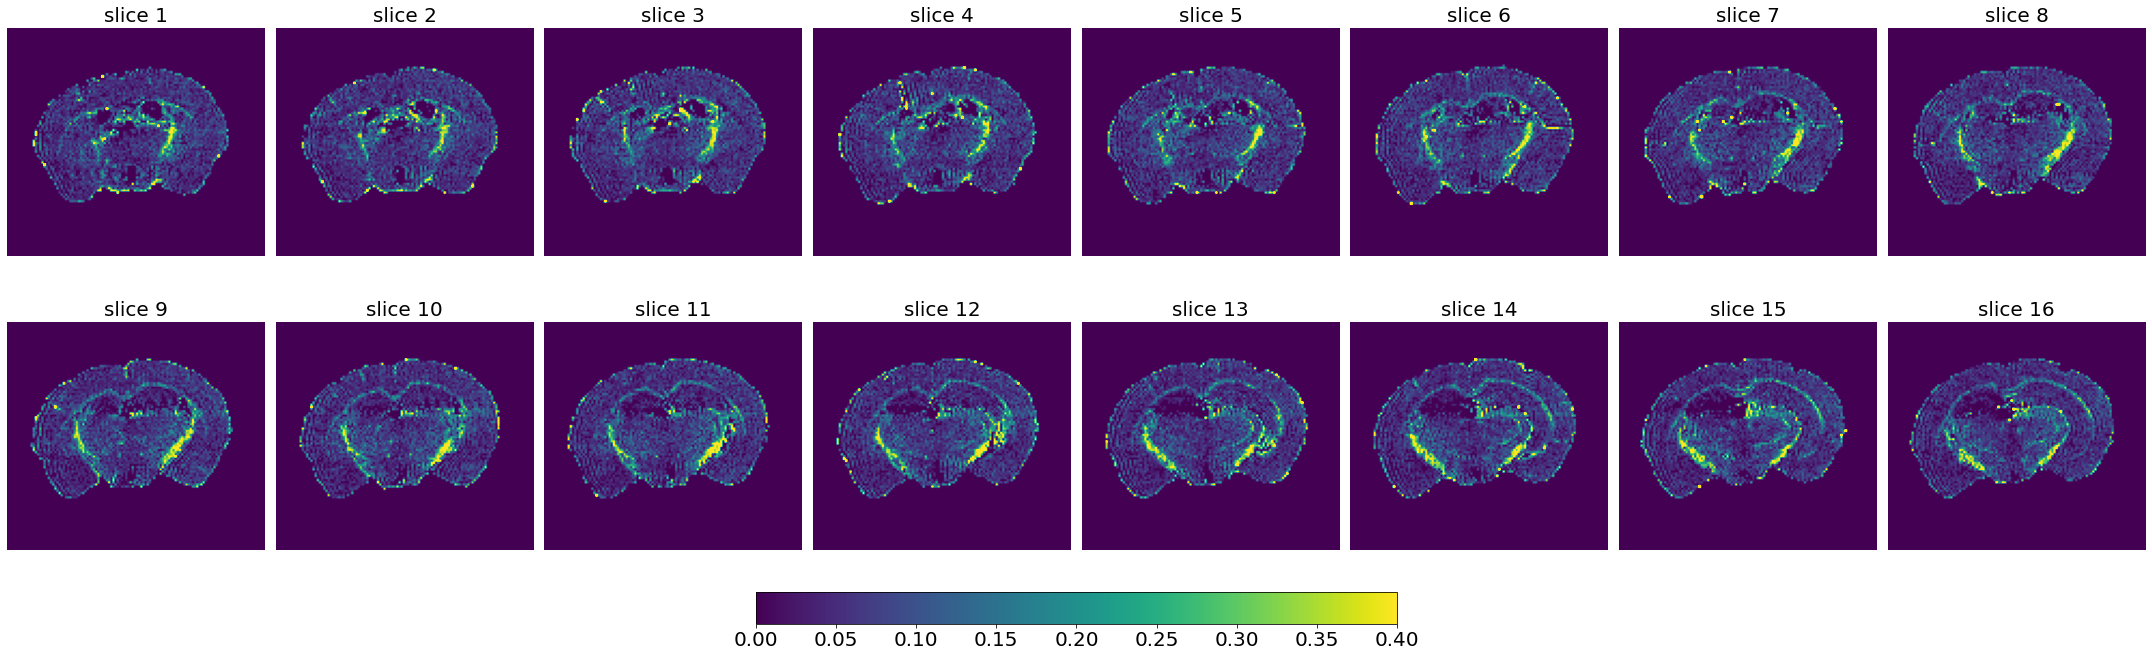

In [253]:
# [12,72,60], [200, 800, 800], 24 echoes
se.plot_all_slice(np.rot90(NN_predict[:,:,60:76],3), nrow=2, ncol=8, vmin=0, vmax=0.4)

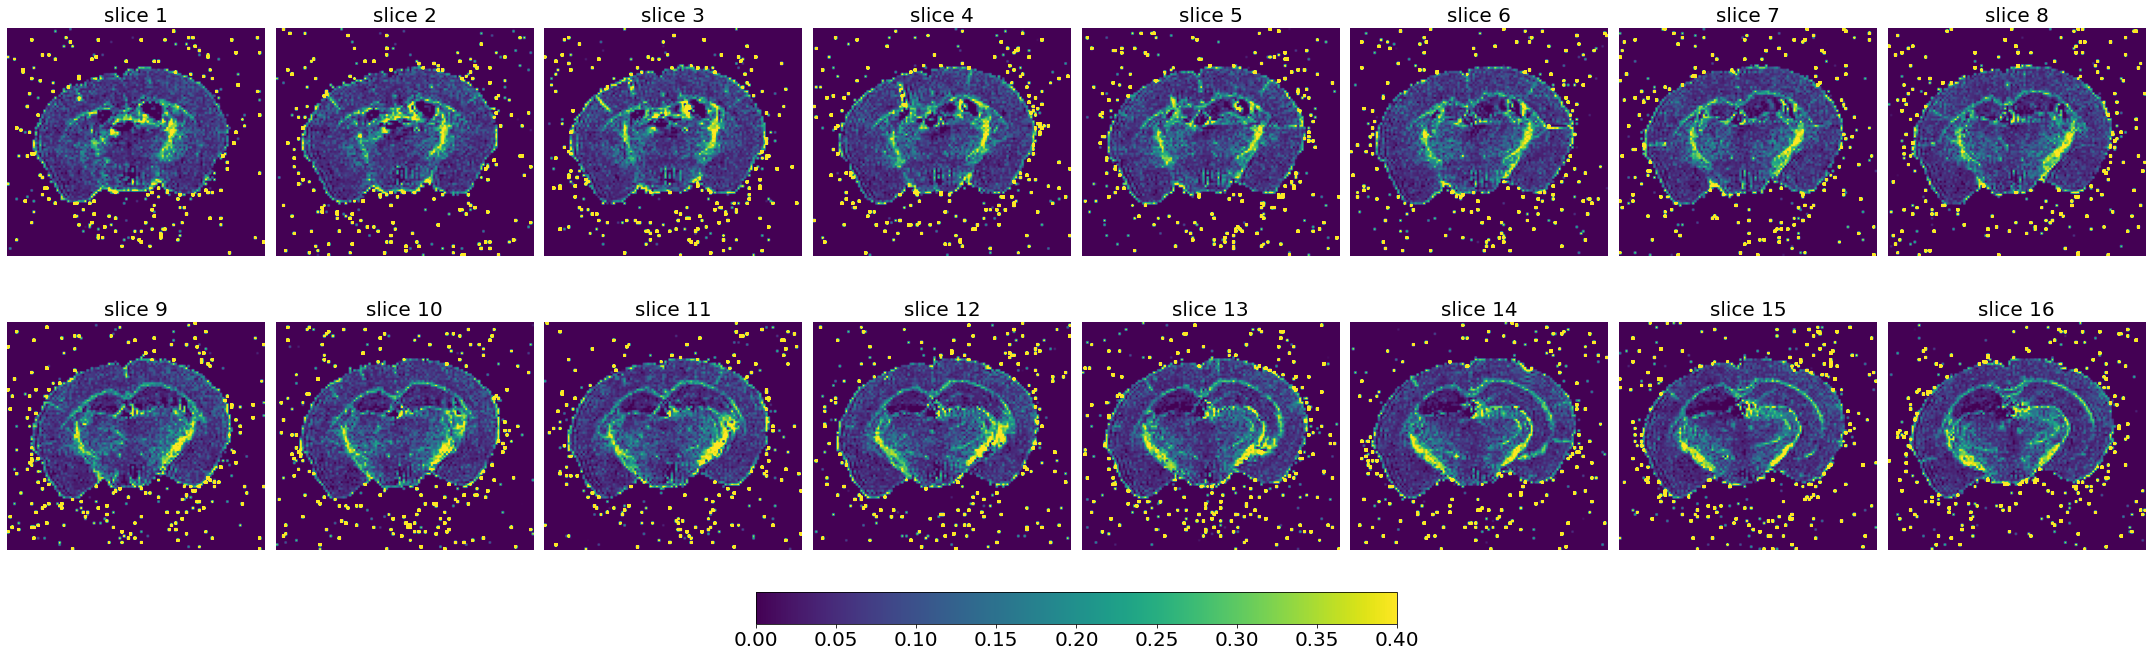

In [181]:
# [12,72,60], [300, 1000, 800], 12 echoes
se.plot_all_slice(np.rot90(NN_predict[:,:,60:76],3), nrow=2, ncol=8, vmin=0, vmax=0.4)

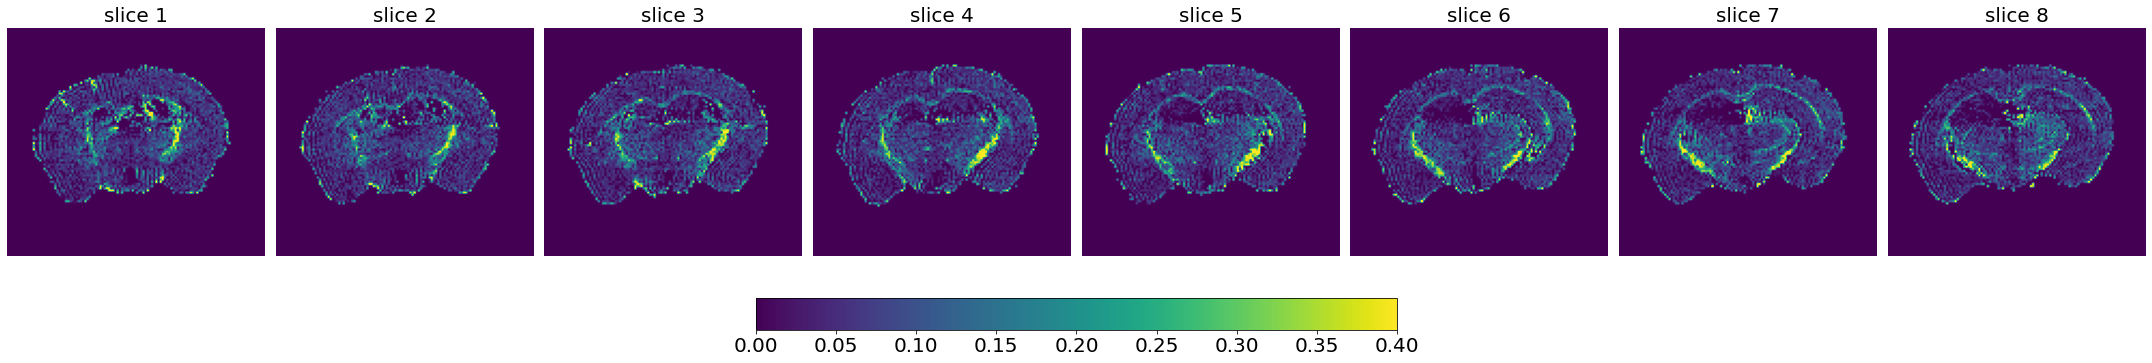

In [446]:
se.plot_all_slice(np.rot90(NN_predict[:,:,62:78:2],3), nrow=1, ncol=8, vmin=0, vmax=0.4)

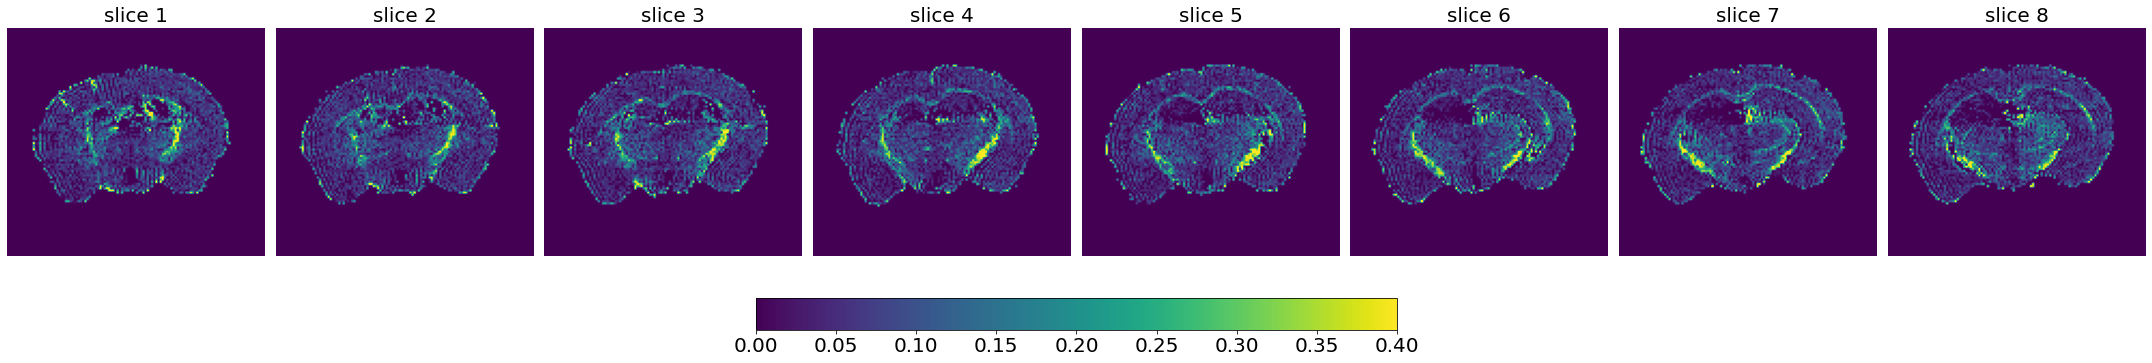

In [401]:
se.plot_all_slice(np.rot90(NN_predict[:,:,62:78:2],3), nrow=1, ncol=8, vmin=0, vmax=0.4)

In [447]:
%store NN_predict

Stored 'NN_predict' (ndarray)


In [418]:
%store -r NNLS_predict_metrics

In [419]:
NNLS_predict_metrics.shape

(120, 106, 135)

In [420]:
NNLS_predict_metrics_save = NNLS_predict_metrics

## NLLS fitting

In [410]:
import scipy.io as sio

In [460]:
NLLS_mwf = sio.loadmat('NLLS_mwf.mat')
NLLS_mwf = NLLS_mwf['fitted_mwf_mag']

In [461]:
NLLS_mwf.shape

(135, 106, 120)

In [462]:
NLLS_mwf = np.swapaxes(NLLS_mwf,0,2)

In [463]:
NLLS_mwf[np.isnan(NLLS_mwf)] = 0

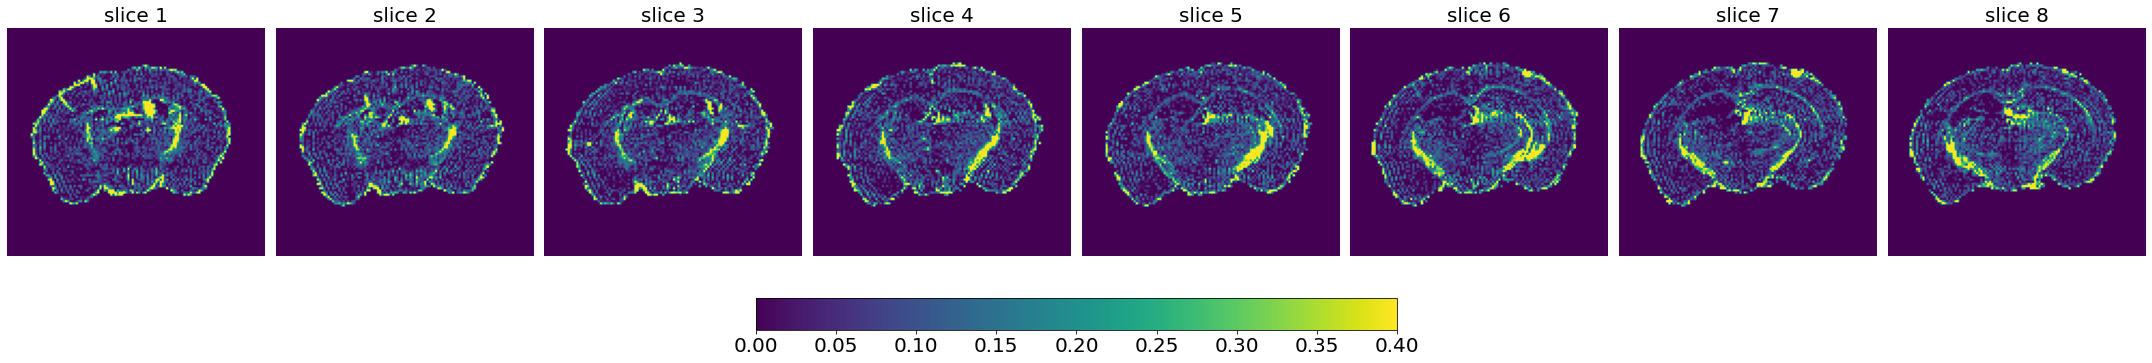

In [464]:
se.plot_all_slice(np.rot90(NLLS_mwf[:,:,62:78:2],3), nrow=1, ncol=8, vmin=0, vmax=0.4)

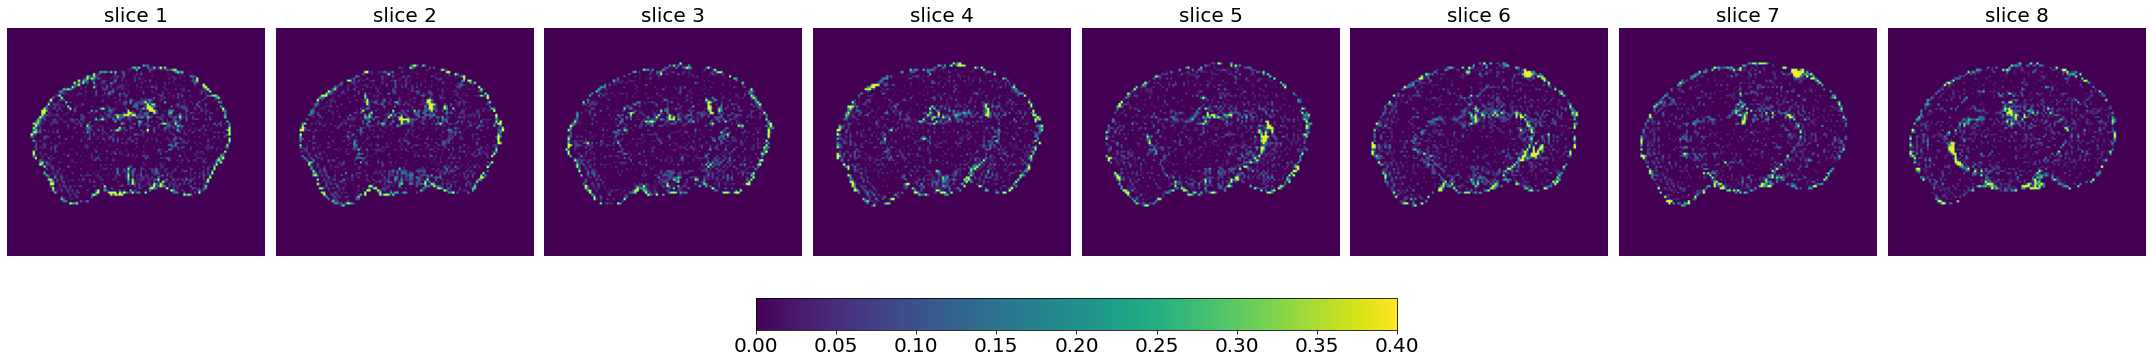

In [466]:
se.plot_all_slice(np.rot90(NLLS_mwf[:,:,62:78:2]-NN_predict[:,:,62:78:2],3), nrow=1, ncol=8, vmin=0, vmax=0.4)

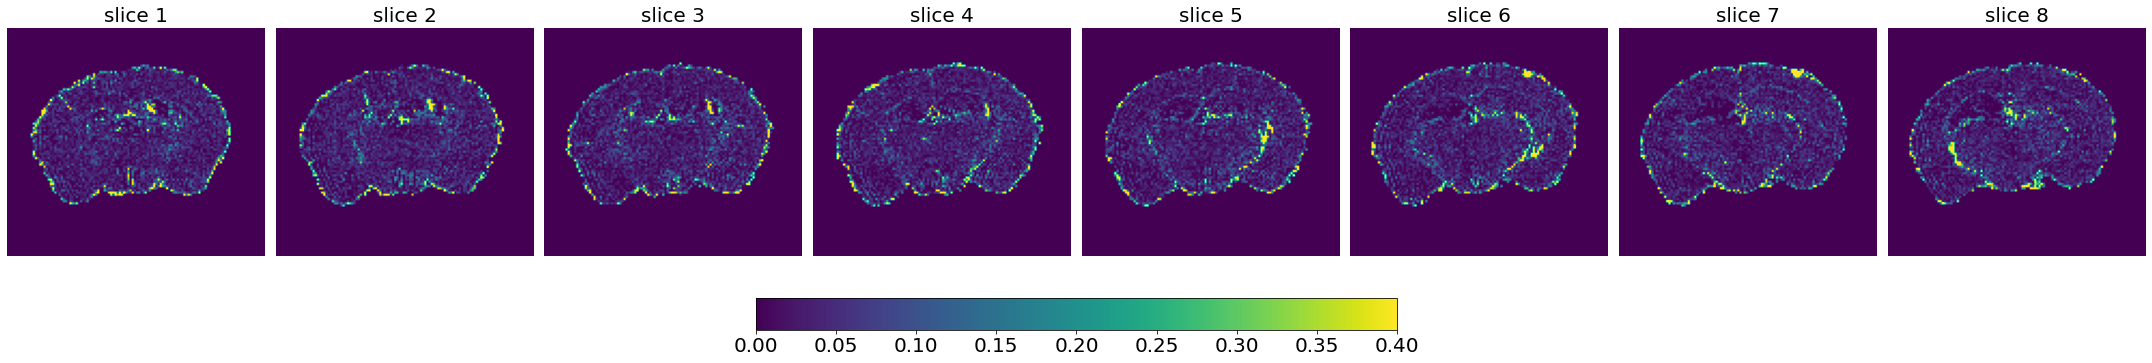

In [465]:
se.plot_all_slice(np.rot90(abs(NLLS_mwf[:,:,62:78:2]-NN_predict[:,:,62:78:2]),3), nrow=1, ncol=8, vmin=0, vmax=0.4)

In [467]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [468]:
np.nanmean(NLLS_mwf-NN_predict)

0.007260711521665442

In [469]:
mean_absolute_error(NLLS_mwf.flatten(), NN_predict.flatten())

0.015336012234424079

In [434]:
NN_predict.shape

(120, 106, 135)

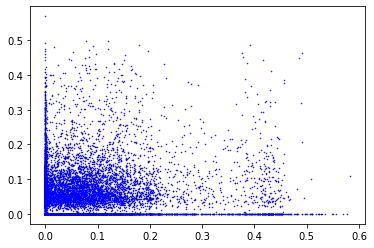

In [436]:
for i in range(120):
    for j in range(106):
        for k in range(66,70,2):
            
            plt.plot(NLLS_mwf[i,j,k], NN_predict[i,j,k], '.', color='blue', markersize=1)

            
            
plt.show()
            